# IBM Data Science: Capstone Project
## The Capstone Notebook


### Introduction

Before COVID-19 threw all other business strategies or plans into complete disarray, Europe was still getting to grips on how Brexit was going to affect the region.

Now that Britain has chosen to leave the EU, many businesses will relocate their head offices outside of London, the world's former financial centre. With this relocation, hundreds of thousands (if not millions) of people will have to uplift their lives and move to another city.

Based on this [forbes article](https://fortune.com/longform/brexit-amsterdam-the-new-london-europe-companies/) Amsterdam could be the 'new London'. If employees are forced to move from the one city to the other, the big question is: which neighborhoods should these soon-to-be ex-Londoners choose to move to in Amsterdam?

Based on Foursquare data, I aim to cluster Amsterdam and London neighborhoods based on similarity. So if you love your neighborhood in London and want something similar in Amsterdam, this is your go-to guide.

### Data

The data I will be using is from accessing the Foursquare API. I will be exploring neighborhoods in London and Amsterdam, using the **explore** function to get the most common venue categories in each neighborhood in the two cities, and then use this feature to group the neighborhoods into clusters. 


I will use the geopy library to get the latitude and longitude values of London and Amsterdam, then use an unsupervised machine learning clustering algorithm, *k*-means, to do the custering. Lastly, I will use the Folium library to colour code the neighborhoods in Amsterdam and London based on their emerging clusters.

## Table of Contents

[Download and Explore Dataset](#first-bullet)

[Explore Neighborhoods in London and Amsterdam](#second-bullet)

[Gathering Foursquare Data](#third-bullet)

[Cluster Neighborhoods](#fourth-bullet)

[Examine Clusters](#fifth-bullet)


In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import GoogleV3 # convert an address into latitude and longitude values

In [3]:
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [4]:
!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /opt/conda/envs/Python36

  added / updated specs: 
    - folium=0.5.0


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    python_abi-3.6             |          1_cp36m           4 KB  conda-forge
    openssl-1.1.1f             |       h516909a_0         2.1 MB  conda-forge
    branca-0.4.0               |             py_0          26 KB  conda-forge
    folium-0.5.0               |             py_0          45 KB  conda-forge
    certifi-2020.4.5.1         |   py36h9f0ad1d_0         151 KB  conda-forge
    altair-4.1.0               |             py_1         614 KB  conda-forge
    vincent-0.4.4              |             py_1          28 KB  conda-forge
    ca-certificates-2020.4.5.1 |       hecc5488_0         146 KB  conda-forge
    ------------------------------------------------------------
                       

## 1. Download and Explore Dataset <a class="anchor" id="first-bullet"></a>
### Scraping Geo-location Data

First we have to scrape the neighborhood, borough and latitude/longitude data for each city.
* To get the London data I scraped [this](https://en.wikipedia.org/wiki/List_of_areas_of_London) wikipedia page.
* To get the Amsterdam data I scraped [this](https://en.wikipedia.org/wiki/Boroughs_of_Amsterdam) wikipedia page.

Then we have to get the foursquare data

### London

In [5]:
#Scraping the London data
#Reading in the table and setting the header to the first row
df = pd.read_html(r'https://en.wikipedia.org/wiki/List_of_areas_of_London', match = 'Location')
df = pd.DataFrame(df[0])
df.head()

,Location,London borough,Post town,Postcode district,Dial code,OS grid ref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [6]:
#setting the column labels
df.columns = ['location', 'borough', 'posttown', 'postcode', 'dialcode', 'OSgridref']
df.head()

,location,borough,posttown,postcode,dialcode,OSgridref
0,Abbey Wood,"Bexley, Greenwich [7]",LONDON,SE2,020,TQ465785
1,Acton,"Ealing, Hammersmith and Fulham[8]",LONDON,"W3, W4",020,TQ205805
2,Addington,Croydon[8],CROYDON,CR0,020,TQ375645
3,Addiscombe,Croydon[8],CROYDON,CR0,020,TQ345665
4,Albany Park,Bexley,"BEXLEY, SIDCUP","DA5, DA14",020,TQ478728


In [7]:
#dropping unnecessary columns
df.drop(['dialcode', 'OSgridref'], axis =1, inplace = True)
df.columns

Index(['location', 'borough', 'posttown', 'postcode'], dtype='object')

In [8]:
#Only selecting the first postal code and first boroughs listed
first_postcode= df.postcode.str.split(",", expand = True)[0]
df['postcode'] = first_postcode

first_borough= df.borough.str.split(",", expand = True)[0]
df['borough'] = first_borough
df.head()

,location,borough,posttown,postcode
0,Abbey Wood,Bexley,LONDON,SE2
1,Acton,Ealing,LONDON,W3
2,Addington,Croydon[8],CROYDON,CR0
3,Addiscombe,Croydon[8],CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP",DA5


In [9]:
# Cleaning up the borough names to remove the square brackets with regex
df.borough = df.borough.map(lambda x: x.rstrip(']').rstrip('0123456789').rstrip('['))
df.head()

,location,borough,posttown,postcode
0,Abbey Wood,Bexley,LONDON,SE2
1,Acton,Ealing,LONDON,W3
2,Addington,Croydon,CROYDON,CR0
3,Addiscombe,Croydon,CROYDON,CR0
4,Albany Park,Bexley,"BEXLEY, SIDCUP",DA5


In [10]:
#only selecting London Neighborhoods and cross referencing that the selection is correct
df = df[df.posttown == "LONDON"]
df.posttown.value_counts()

LONDON    299
Name: posttown, dtype: int64

In [11]:
#dropping the posttown field as it doesnt add value anymore
df.drop(['posttown'], axis =1, inplace = True)
df.reset_index(drop=True, inplace = True)

In [12]:
df.head()

,location,borough,postcode
0,Abbey Wood,Bexley,SE2
1,Acton,Ealing,W3
2,Aldgate,City,EC3
3,Aldwych,Westminster,WC2
4,Anerley,Bromley,SE20


In [13]:
# The code was removed by Watson Studio for sharing.

In [14]:
from geopy.geocoders import GoogleV3 # convert an address into latitude and longitude values

In [15]:
geolocator = GoogleV3(api_key = googlemaps_api_key, domain = 'maps.google.co.uk')
location = geolocator.geocode('SE2, London, United Kingdom')
location.latitude, location.longitude

(51.4860421, 0.1202586)

In [16]:
def get_lat_long_london(postcode):
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        address = '{}, London, United Kingdom'.format(postcode)
        geolocator = GoogleV3(api_key = googlemaps_api_key, domain = 'maps.google.co.uk')
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        lat_lng_coords = [latitude, longitude]
    return lat_lng_coords


In [17]:
#testing
get_lat_long_london('SE2')

[51.4860421, 0.1202586]

In [18]:
#Using comprehension to create the data for our additional columns
post_codes = [get_lat_long_london(p) for p in df['postcode'].to_list()]

In [19]:
#creating the dataframe which we will append to the end of our existing dataframe
df_c = pd.DataFrame(post_codes, columns = ['latitude', 'longitude'])
df_c.head()

,latitude,longitude
0,51.486042,0.120259
1,51.512075,-0.267572
2,51.515987,-0.078379
3,51.510583,-0.126768
4,51.412571,-0.061397


In [20]:
df_lon = pd.concat([df, df_c], axis=1)
df_lon.head()

,location,borough,postcode,latitude,longitude
0,Abbey Wood,Bexley,SE2,51.486042,0.120259
1,Acton,Ealing,W3,51.512075,-0.267572
2,Aldgate,City,EC3,51.515987,-0.078379
3,Aldwych,Westminster,WC2,51.510583,-0.126768
4,Anerley,Bromley,SE20,51.412571,-0.061397


### Amsterdam

In [21]:
#Scraping the Amsterdam data
#Reading in the table and setting the header to the first row
df = pd.read_html(r'https://en.wikipedia.org/wiki/Boroughs_of_Amsterdam', match = 'Area')
df = pd.DataFrame(df[0])
df.head()

,Borough,Area,Population,Population density,Location (in green),Neighbourhoods
0,Centrum (Centre),8.04 km²,86422,"13,748/km²",NaN,"Binnenstad, Grachtengordel, Haarlemmerbuurt, J..."
1,Noord (North),49.01 km²,94766,"2,269/km²",NaN,"Banne Buiksloot, Buiksloot, Buikslotermeer, Fl..."
2,Nieuw-West(New West),32.38 km²,151677,"4,478/km²",NaN,"Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O..."
3,Oost (East),30.56 km²,135767,"7,635/km²",NaN,"IJburg, Indische Buurt, Eastern Docklands, Oud..."
4,West,9.89 km²,143842,"15,252/km²",NaN,"Frederik Hendrikbuurt, Houthaven, Spaarndammer..."


In [22]:
#renaming the columns fo ease of use
df.columns = ['borough', 'area', 'population', 'populationdensity', 'location', 'neighborhoods']
df.head()

,borough,area,population,populationdensity,location,neighborhoods
0,Centrum (Centre),8.04 km²,86422,"13,748/km²",NaN,"Binnenstad, Grachtengordel, Haarlemmerbuurt, J..."
1,Noord (North),49.01 km²,94766,"2,269/km²",NaN,"Banne Buiksloot, Buiksloot, Buikslotermeer, Fl..."
2,Nieuw-West(New West),32.38 km²,151677,"4,478/km²",NaN,"Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O..."
3,Oost (East),30.56 km²,135767,"7,635/km²",NaN,"IJburg, Indische Buurt, Eastern Docklands, Oud..."
4,West,9.89 km²,143842,"15,252/km²",NaN,"Frederik Hendrikbuurt, Houthaven, Spaarndammer..."


In [23]:
#dropping columns that I don't need
df = df[['borough','neighborhoods']]
df.head()

,borough,neighborhoods
0,Centrum (Centre),"Binnenstad, Grachtengordel, Haarlemmerbuurt, J..."
1,Noord (North),"Banne Buiksloot, Buiksloot, Buikslotermeer, Fl..."
2,Nieuw-West(New West),"Geuzenveld, Nieuw Sloten, Oostoever, Osdorp, O..."
3,Oost (East),"IJburg, Indische Buurt, Eastern Docklands, Oud..."
4,West,"Frederik Hendrikbuurt, Houthaven, Spaarndammer..."


In [24]:
#We now need to rearrange the table so that we only have a neighborhood and borough column.
#We start by splitting the neighborhood column into many columns, and add the 'neighborhood' prefix for ease of use
df_split= df.neighborhoods.str.split(",", expand = True)
df_split = df_split.add_prefix('Neighborhood_')
df_split.head()

,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13
0,Binnenstad,Grachtengordel,Haarlemmerbuurt,Jodenbuurt,Jordaan,Kadijken,Lastage,Oosterdokseiland,Oostelijke Eilanden,Plantage,Rapenburg,Uilenburg,Westelijke Eilanden,Weteringschans
1,Banne Buiksloot,Buiksloot,Buikslotermeer,Floradorp,Kadoelen,Molenwijk,Nieuwendam,Nieuwendammerdijk en Buiksloterdijk,Oostzanerwerf,Overhoeks,Tuindorp Nieuwendam,Tuindorp Oostzaan,None,None
2,Geuzenveld,Nieuw Sloten,Oostoever,Osdorp,Overtoomse Veld,Sloten,Slotermeer,Slotervaart,None,None,None,None,None,None
3,IJburg,Indische Buurt,Eastern Docklands,Oud-Oost,Watergraafsmeer,None,None,None,None,None,None,None,None,None
4,Frederik Hendrikbuurt,Houthaven,Spaarndammerbuurt,Staatsliedenbuurt,Zeeheldenbuurt,Westerpark,Kinkerbuurt,Overtoombuurt,De Baarsjes,Bos en Lommer,Kolenkitbuurt,Landlust,Sloterdijk,None


In [25]:
#we then join the dataframes back together again and drop the repetitive 'neighborhoods' columns
df_new = pd.concat([df, df_split], axis = 1)
df_new.drop(['neighborhoods'], axis = 1, inplace = True)
df_new

,borough,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13
0,Centrum (Centre),Binnenstad,Grachtengordel,Haarlemmerbuurt,Jodenbuurt,Jordaan,Kadijken,Lastage,Oosterdokseiland,Oostelijke Eilanden,Plantage,Rapenburg,Uilenburg,Westelijke Eilanden,Weteringschans
1,Noord (North),Banne Buiksloot,Buiksloot,Buikslotermeer,Floradorp,Kadoelen,Molenwijk,Nieuwendam,Nieuwendammerdijk en Buiksloterdijk,Oostzanerwerf,Overhoeks,Tuindorp Nieuwendam,Tuindorp Oostzaan,None,None
2,Nieuw-West(New West),Geuzenveld,Nieuw Sloten,Oostoever,Osdorp,Overtoomse Veld,Sloten,Slotermeer,Slotervaart,None,None,None,None,None,None
3,Oost (East),IJburg,Indische Buurt,Eastern Docklands,Oud-Oost,Watergraafsmeer,None,None,None,None,None,None,None,None,None
4,West,Frederik Hendrikbuurt,Houthaven,Spaarndammerbuurt,Staatsliedenbuurt,Zeeheldenbuurt,Westerpark,Kinkerbuurt,Overtoombuurt,De Baarsjes,Bos en Lommer,Kolenkitbuurt,Landlust,Sloterdijk,None
5,Westpoort(West Gateway),Westpoort,None,None,None,None,None,None,None,None,None,None,None,None,None
6,Zuid (South),Apollobuurt,Buitenveldert,Hoofddorppleinbuurt,Museumkwartier,De Pijp,Prinses Irenebuurt,Rivierenbuurt,Schinkelbuurt,Stadionbuurt,Vondelpark,Willemspark,Zuidas,None,None
7,Zuidoost(Southeast),Bijlmermeer,Venserpolder,Gaasperdam,Driemond,None,None,None,None,None,None,None,None,None,None


In [26]:
#we then use melt to get our two columns
df_new.set_index('borough', inplace =  True)
df_new.head()
#df_new.pivot(index = 'borough', columns = df.columns[1:])

,Neighborhood_0,Neighborhood_1,Neighborhood_2,Neighborhood_3,Neighborhood_4,Neighborhood_5,Neighborhood_6,Neighborhood_7,Neighborhood_8,Neighborhood_9,Neighborhood_10,Neighborhood_11,Neighborhood_12,Neighborhood_13
borough,,,,,,,,,,,,,,
Centrum (Centre),Binnenstad,Grachtengordel,Haarlemmerbuurt,Jodenbuurt,Jordaan,Kadijken,Lastage,Oosterdokseiland,Oostelijke Eilanden,Plantage,Rapenburg,Uilenburg,Westelijke Eilanden,Weteringschans
Noord (North),Banne Buiksloot,Buiksloot,Buikslotermeer,Floradorp,Kadoelen,Molenwijk,Nieuwendam,Nieuwendammerdijk en Buiksloterdijk,Oostzanerwerf,Overhoeks,Tuindorp Nieuwendam,Tuindorp Oostzaan,None,None
Nieuw-West(New West),Geuzenveld,Nieuw Sloten,Oostoever,Osdorp,Overtoomse Veld,Sloten,Slotermeer,Slotervaart,None,None,None,None,None,None
Oost (East),IJburg,Indische Buurt,Eastern Docklands,Oud-Oost,Watergraafsmeer,None,None,None,None,None,None,None,None,None
West,Frederik Hendrikbuurt,Houthaven,Spaarndammerbuurt,Staatsliedenbuurt,Zeeheldenbuurt,Westerpark,Kinkerbuurt,Overtoombuurt,De Baarsjes,Bos en Lommer,Kolenkitbuurt,Landlust,Sloterdijk,None


In [27]:
#Cleaning up the dataframe
df = pd.DataFrame(df_new.stack(level=0))
df.index = df.index.get_level_values('borough')
df.reset_index(drop =False, inplace =True)
df.rename(columns = {0:'neighborhood'}, inplace = True)
df.head()

,borough,neighborhood
0,Centrum (Centre),Binnenstad
1,Centrum (Centre),Grachtengordel
2,Centrum (Centre),Haarlemmerbuurt
3,Centrum (Centre),Jodenbuurt
4,Centrum (Centre),Jordaan


In [28]:
#we now need to remove the english translation within the brackets by using regex
df['borough'] = df['borough'].str.replace(r'\([^()]*\)', '')
df.head()

,borough,neighborhood
0,Centrum,Binnenstad
1,Centrum,Grachtengordel
2,Centrum,Haarlemmerbuurt
3,Centrum,Jodenbuurt
4,Centrum,Jordaan


In [29]:
#Now using the get_lat_lng function we used earlier on the amsterdam data, we have to change the domain and address string:
geolocator = GoogleV3(api_key = googlemaps_api_key, domain = 'maps.google.co.uk')

In [30]:
def get_lat_long_amsterdam(neighborhood):
    # Initialize the Location (lat. and long.) to "None"
    lat_lng_coords = None
    
    # While loop helps to create a continous run until all the location coordinates are geocoded
    while(lat_lng_coords is None):
        address = '{}, Amsterdam, Nederland'.format(neighborhood)
        geolocator = GoogleV3(api_key = googlemaps_api_key, domain = 'maps.google.co.uk')
        location = geolocator.geocode(address)
        latitude = location.latitude
        longitude = location.longitude
        lat_lng_coords = [latitude, longitude]
    return lat_lng_coords


In [31]:
#checking that it works
location = geolocator.geocode('Grachtengordel, Amsterdam, Nederland')
location.latitude, location.longitude
print (location.latitude, location.longitude)
print('It works!')

52.3655774 4.8893609
It works!


In [32]:
#Using comprehension to create the data for our additional columns
post_codes = [get_lat_long_amsterdam(n) for n in df['neighborhood'].to_list()]
post_codes[0]

[52.3733862, 4.8940639]

In [33]:
#creating the dataframe which we will append to the end of our existing dataframe
df_am_lat_lng = pd.DataFrame(post_codes, columns = ['latitude', 'longitude'])
df_am_lat_lng.head()

,latitude,longitude
0,52.373386,4.894064
1,52.365577,4.889361
2,52.384254,4.889344
3,52.368263,4.904020
4,52.373931,4.880876


In [34]:
df_am = pd.concat([df, df_am_lat_lng], axis=1)
df_am.head()

,borough,neighborhood,latitude,longitude
0,Centrum,Binnenstad,52.373386,4.894064
1,Centrum,Grachtengordel,52.365577,4.889361
2,Centrum,Haarlemmerbuurt,52.384254,4.889344
3,Centrum,Jodenbuurt,52.368263,4.904020
4,Centrum,Jordaan,52.373931,4.880876


### Now concatenating the two dataframes by row (on top of one another), we get the final dataframe

In [35]:
df_lon.head()

,location,borough,postcode,latitude,longitude
0,Abbey Wood,Bexley,SE2,51.486042,0.120259
1,Acton,Ealing,W3,51.512075,-0.267572
2,Aldgate,City,EC3,51.515987,-0.078379
3,Aldwych,Westminster,WC2,51.510583,-0.126768
4,Anerley,Bromley,SE20,51.412571,-0.061397


In [36]:
df_am.head()

,borough,neighborhood,latitude,longitude
0,Centrum,Binnenstad,52.373386,4.894064
1,Centrum,Grachtengordel,52.365577,4.889361
2,Centrum,Haarlemmerbuurt,52.384254,4.889344
3,Centrum,Jodenbuurt,52.368263,4.904020
4,Centrum,Jordaan,52.373931,4.880876


In [37]:
df_am = df_am[['neighborhood', 'borough', 'latitude', 'longitude']]
df_am['city'] = 'Amsterdam'
df_am.head()

,neighborhood,borough,latitude,longitude,city
0,Binnenstad,Centrum,52.373386,4.894064,Amsterdam
1,Grachtengordel,Centrum,52.365577,4.889361,Amsterdam
2,Haarlemmerbuurt,Centrum,52.384254,4.889344,Amsterdam
3,Jodenbuurt,Centrum,52.368263,4.904020,Amsterdam
4,Jordaan,Centrum,52.373931,4.880876,Amsterdam


In [38]:
#Because we dont have the post codes for Amsterdam- and given that we actually don't need them , we can drop it before we concatenate.
df_lon.drop(['postcode'], axis = 1, inplace =True)

In [39]:
df_lon.rename({'location': 'neighborhood'}, axis = 1, inplace = True)
df_lon['city'] = 'london'

In [40]:
df_am_lon = pd.concat([df_lon, df_am])
df_am_lon.reset_index(drop =True, inplace =True)
df_am_lon.head()

,neighborhood,borough,latitude,longitude,city
0,Abbey Wood,Bexley,51.486042,0.120259,london
1,Acton,Ealing,51.512075,-0.267572,london
2,Aldgate,City,51.515987,-0.078379,london
3,Aldwych,Westminster,51.510583,-0.126768,london
4,Anerley,Bromley,51.412571,-0.061397,london


In [41]:
df_am_lon.shape

(368, 5)

In [42]:
df_am_lon.drop_duplicates(subset ="neighborhood", keep=False,inplace=True) 

In [43]:
df_am_lon.shape

(364, 5)

## 2. Explore Neighborhoods in London and Amsterdam <a class="anchor" id="second-bullet"></a>

In [44]:
# Having a look at the two cities using a folium map
#Looking at Amsterdam first
location = geolocator.geocode( 'Amsterdam, Nederland')
lat_am = location.latitude
lng_am = location.longitude
print (lat_am, lng_am)

52.3666969 4.8945398


In [45]:
# create map of Amsterdam using latitude and longitude values
map_am= folium.Map(location=[lat_am, lng_am], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_am['latitude'], df_am['longitude'], df_am['borough'], df_am['neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_am)  
    
map_am

In [46]:
# Having a look at the two cities using a folium map
#Looking at London
location = geolocator.geocode( 'London, United Kingdom')
lat_lon = location.latitude
lng_lon = location.longitude
print (lat_lon, lng_lon)

51.5073509 -0.1277583


In [47]:
# create map of Amsterdam using latitude and longitude values
map_lon= folium.Map(location=[lat_lon, lng_lon], zoom_start=12)

# add markers to map
for lat, lng, borough, neighborhood in zip(df_lon['latitude'], df_lon['longitude'], df_lon['borough'], df_lon['neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_lon)  
    
map_lon

In [48]:
df_am_lon.shape

(364, 5)

In [49]:
df_am_lon.borough.nunique()

41

In [50]:
df_am_lon.groupby(by = ['city']).count()['neighborhood']

city
Amsterdam     69
london       295
Name: neighborhood, dtype: int64

In [51]:
a = df_am_lon.groupby(by = ['city'])['borough'].value_counts()

### Findings from our initial neighborhood data

We now have a final dataframe with  368 neighborhoods across both cities.
Given the size of London compared to Amsterdam, it's no surprise that London has over 3 times as many neighborhoods.
* London has 299 Neighborhoods
* Amsterdam has 69 Neighborhoods

In total, there are 41 unique Boroughs between the two cities.
* The Borough with the most neighborhoods in Amsterdam is Centrum with 14 Neighborhoods.
* The Borough with the most neighborhoods in London is Barnet with 26 Neighborhoods.

If we take a look at each folium map, we can see that London as a geographic region is much bigger than Amsterdam.

## 3. Gathering Foursquare Data <a class="anchor" id="third-bullet"></a>

In [52]:
import requests # library to handle requests
import matplotlib.cm as cm
import matplotlib.colors as colors
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [53]:
# The code was removed by Watson Studio for sharing.

In [54]:
#Exploring the first neighborhood in our dataset- 'Abbey Wood'

df_am_lon.loc[0, 'neighborhood']

'Abbey Wood'

#### Now, let's get the top 50 venues that are in Regent Park within a radius of 500 meters.

In [55]:
neighborhood_name = df_am_lon.loc[0, 'neighborhood']
neighborhood_latitude = df_am_lon.loc[0, 'latitude']
neighborhood_longitude = df_am_lon.loc[0, 'longitude']

LIMIT = 50 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

# create URL
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    neighborhood_latitude, 
    neighborhood_longitude, 
    radius, 
    LIMIT)
url # display URL

'https://api.foursquare.com/v2/venues/explore?&client_id=HSNVL3XPEP1ZEFL5PKKJDKHOFMSNBCM5WQ0JJL51RY5AV3GG&client_secret=GGRC30CTORKYNVWCDJOTTTUIPUJYYPBSBNEABBWXU13OJCOR&v=20180605&ll=51.4860421,0.1202586&radius=500&limit=50'

In [56]:
#Sending the GET request to examine the results
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5e95836a95feaf001bb33c87'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Abbey Wood',
  'headerFullLocation': 'Abbey Wood, London',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 3,
  'suggestedBounds': {'ne': {'lat': 51.4905421045, 'lng': 0.12747164715160642},
   'sw': {'lat': 51.4815420955, 'lng': 0.11304555284839356}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '52ff5c17498ea6224a14a31f',
       'name': 'Greggs',
       'location': {'address': '7 Wilton Rd',
        'lat': 51.490164,
        'lng': 0.121305,
        'labeledLatLngs': [{'label': 'display',
          'lat': 51.490164,


In [57]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [58]:
#Cleaning Json and putting into pandas DF structure
venues = results['response']['groups'][0]['items']
venues

[{'reasons': {'count': 0,
   'items': [{'summary': 'This spot is popular',
     'type': 'general',
     'reasonName': 'globalInteractionReason'}]},
  'venue': {'id': '52ff5c17498ea6224a14a31f',
   'name': 'Greggs',
   'location': {'address': '7 Wilton Rd',
    'lat': 51.490164,
    'lng': 0.121305,
    'labeledLatLngs': [{'label': 'display',
      'lat': 51.490164,
      'lng': 0.121305}],
    'distance': 464,
    'postalCode': 'SE2 9RH',
    'cc': 'GB',
    'city': 'Abbey Wood',
    'state': 'Greater London',
    'country': 'United Kingdom',
    'formattedAddress': ['7 Wilton Rd',
     'Abbey Wood',
     'Greater London',
     'SE2 9RH',
     'United Kingdom']},
   'categories': [{'id': '4bf58dd8d48988d16a941735',
     'name': 'Bakery',
     'pluralName': 'Bakeries',
     'shortName': 'Bakery',
     'icon': {'prefix': 'https://ss3.4sqi.net/img/categories_v2/food/bakery_',
      'suffix': '.png'},
     'primary': True}],
   'photos': {'count': 0, 'groups': []}},
  'referralId': 'e-0-52

In [59]:
nearby_venues = json_normalize(venues) # flatten JSON
nearby_venues.head()

,reasons.count,reasons.items,referralId,venue.categories,venue.id,venue.location.address,venue.location.cc,venue.location.city,venue.location.country,venue.location.distance,venue.location.formattedAddress,venue.location.labeledLatLngs,venue.location.lat,venue.location.lng,venue.location.postalCode,venue.location.state,venue.name,venue.photos.count,venue.photos.groups
0,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-52ff5c17498ea6224a14a31f-0,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",52ff5c17498ea6224a14a31f,7 Wilton Rd,GB,Abbey Wood,United Kingdom,464,"[7 Wilton Rd, Abbey Wood, Greater London, SE2 ...","[{'label': 'display', 'lat': 51.490164, 'lng':...",51.490164,0.121305,SE2 9RH,Greater London,Greggs,0,[]
1,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-4d826745bb2c5481b93be3ab-1,"[{'id': '4bf58dd8d48988d1e4941735', 'name': 'C...",4d826745bb2c5481b93be3ab,NaN,GB,NaN,United Kingdom,62,[United Kingdom],"[{'label': 'display', 'lat': 51.48550163169358...",51.485502,0.120014,NaN,NaN,Abbey Wood Caravan Club,0,[]
2,0,"[{'summary': 'This spot is popular', 'type': '...",e-0-5191ffc5498e4913b76a852f-2,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",5191ffc5498e4913b76a852f,183 Abbey Wood Rd,GB,NaN,United Kingdom,415,"[183 Abbey Wood Rd, SE2 9DZ, United Kingdom]","[{'label': 'display', 'lat': 51.48975372314453...",51.489754,0.120822,SE2 9DZ,NaN,Abbey Cafe,0,[]


In [60]:
# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Greggs,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",51.490164,0.121305
1,Abbey Wood Caravan Club,"[{'id': '4bf58dd8d48988d1e4941735', 'name': 'C...",51.485502,0.120014
2,Abbey Cafe,"[{'id': '4bf58dd8d48988d16d941735', 'name': 'C...",51.489754,0.120822


In [61]:
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Greggs,Bakery,51.490164,0.121305
1,Abbey Wood Caravan Club,Campground,51.485502,0.120014
2,Abbey Cafe,Café,51.489754,0.120822


In [66]:
# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]
nearby_venues.columns

Index(['name', 'categories', 'lat', 'lng'], dtype='object')

In [67]:
nearby_venues.head()

,name,categories,lat,lng
0,Greggs,Bakery,51.490164,0.121305
1,Abbey Wood Caravan Club,Campground,51.485502,0.120014
2,Abbey Cafe,Café,51.489754,0.120822


In [68]:
#Creating a function to repeat the same for all neighborhoods in our London and Amsterdam dataset
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [69]:
am_lon_venues = getNearbyVenues(names=df_am_lon['neighborhood'],
                                   latitudes=df_am_lon['latitude'],
                                   longitudes=df_am_lon['longitude']
                                  )

Abbey Wood
Acton
Aldgate
Aldwych
Anerley
Angel
Archway
Arnos Grove
Balham
Bankside
Barbican
Barnes
Barnsbury
Battersea
Bayswater
Bedford Park
Belgravia
Bellingham
Belsize Park
Bermondsey
Bethnal Green
Blackfriars
Blackheath
Blackheath Royal Standard
Blackwall
Bloomsbury
Bounds Green
Bow
Bowes Park
Brent Cross
Brent Park
Brixton
Brockley
Bromley (also Bromley-by-Bow)
Brompton
Brondesbury
Brunswick Park
Burroughs, The
Camberwell
Cambridge Heath
Camden Town
Canary Wharf
Cann Hall
Canning Town
Canonbury
Castelnau
Catford
Chalk Farm
Charing Cross
Charlton
Chelsea
Childs Hill
Chinatown
Chinbrook
Chingford
Chiswick
Clapham
Clerkenwell
Colindale
Colliers Wood
Colney Hatch
Covent Garden
Cricklewood
Crofton Park
Crossness
Crouch End
Crystal Palace
Cubitt Town
Custom House
Dalston
Dartford
De Beauvoir Town
Denmark Hill
Deptford
Dollis Hill
Dulwich
Ealing
Earls Court
Earlsfield
East Dulwich
East Finchley
East Ham
East Sheen
Edmonton
Elephant and Castle
Eltham
Farringdon
Finchley
Finsbury
Finsbury 

In [70]:
#Sizing and getting a view of the data
print(am_lon_venues.shape)
am_lon_venues.head()

(9193, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Abbey Wood,51.486042,0.120259,Greggs,51.490164,0.121305,Bakery
1,Abbey Wood,51.486042,0.120259,Abbey Wood Caravan Club,51.485502,0.120014,Campground
2,Abbey Wood,51.486042,0.120259,Abbey Cafe,51.489754,0.120822,Café
3,Acton,51.512075,-0.267572,Bake Me,51.508452,-0.268543,Creperie
4,Acton,51.512075,-0.267572,The Station House,51.508877,-0.263076,Pub


In [71]:
#Seeing how many venues we get per neighborhood
am_lon_venues.groupby('Neighborhood').count().head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Bos en Lommer,38,38,38,38,38,38
Buiksloot,10,10,10,10,10,10
Buikslotermeer,31,31,31,31,31,31
Buitenveldert,19,19,19,19,19,19
De Baarsjes,44,44,44,44,44,44


#### Analysing each neighborhood

In [72]:
# one hot encoding
am_lon_onehot = pd.get_dummies(am_lon_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
am_lon_onehot['Neighborhood'] = am_lon_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [am_lon_onehot.columns[-1]] + list(am_lon_onehot.columns[:-1])
am_lon_onehot = am_lon_onehot[fixed_columns]

am_lon_onehot.head()

,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Quad,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nature Preserve,Neighborhood,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Observatory,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Gym,Outdoor Sculpture,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,

In [73]:
#Grouping the rows by neighborhood and taking the mean of the frequency of the occurance
am_lon_grouped = am_lon_onehot.groupby('Neighborhood').mean().reset_index()
am_lon_grouped.head()

,Neighborhood,Zoo Exhibit,Accessories Store,Afghan Restaurant,African Restaurant,American Restaurant,Antique Shop,Aquarium,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Austrian Restaurant,Auto Garage,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bar,Baseball Field,Beach,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Betting Shop,Bike Rental / Bike Share,Bike Shop,Bistro,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brasserie,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Burger Joint,Burrito Place,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Carpet Store,Casino,Champagne Bar,Cheese Shop,Chinese Restaurant,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Cafeteria,College Quad,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Costume Shop,Coworking Space,Creperie,Cricket Ground,Cupcake Shop,Currywurst Joint,Cycle Studio,Czech Restaurant,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dive Bar,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dumpling Restaurant,Dutch Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Fondue Restaurant,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Football Stadium,Forest,Fountain,French Restaurant,Fried Chicken Joint,Friterie,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General Entertainment,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Harbor / Marina,Hardware Store,Health & Beauty Service,Health Food Store,Herbs & Spices Store,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Hockey Field,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kebab Restaurant,Kids Store,Kitchen Supply Store,Knitting Store,Korean Restaurant,Lake,Latin American Restaurant,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Marijuana Dispensary,Market,Massage Studio,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Multiplex,Museum,Music School,Music Store,Music Venue,Nature Preserve,New American Restaurant,Nightclub,Noodle House,North Indian Restaurant,Observatory,Office,Opera House,Optical Shop,Organic Grocery,Outdoor Gym,Outdoor Sculpture,Outdoors & Recreation,Palace,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Café,Pet Store,Pharmacy,Piano Bar,Pie Shop,Pier,Pilates Studio,Pizza Place,Planetarium,Platform,Playground,Plaza,Poke Place,Polish Restaurant,Pool,Pool Hall,Portuguese Restaurant,Print Shop,Pub,Public Art,Ramen Restaurant,Record Shop,Recording Studio,Recreation Center,Rental Car Location,Rental Service,Residential Building (Apartment / Condo),Restaurant,River,

In [74]:
#Printing each neighborhood along with the 5 most common venues
num_top_venues = 5

for hood in am_lon_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = am_lon_grouped[am_lon_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Bos en Lommer----
                           venue  freq
0                   Tram Station  0.08
1                         Bakery  0.05
2          Indonesian Restaurant  0.05
3                    Coffee Shop  0.05
4  Vegetarian / Vegan Restaurant  0.05


---- Buiksloot----
           venue  freq
0       Bus Stop   0.2
1           Park   0.2
2    Supermarket   0.2
3  Shopping Mall   0.1
4         Bakery   0.1


---- Buikslotermeer----
               venue  freq
0        Supermarket  0.10
1     Clothing Store  0.10
2  Convenience Store  0.06
3          Drugstore  0.06
4     Discount Store  0.03


---- Buitenveldert----
          venue  freq
0     Drugstore  0.11
1   Snack Place  0.05
2  Tram Station  0.05
3   Supermarket  0.05
4        Bakery  0.05


---- De Baarsjes----
                venue  freq
0                 Bar  0.09
1       Deli / Bodega  0.05
2          Restaurant  0.05
3  Falafel Restaurant  0.05
4    Greek Restaurant  0.05


---- De Pijp----
                           ve

In [75]:
#Writing a function to sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [76]:
#Creating a new DF to display the top venues for each neighborhood
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = am_lon_grouped['Neighborhood']

for ind in np.arange(am_lon_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(am_lon_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bos en Lommer,Tram Station,Bar,Vegetarian / Vegan Restaurant,Bakery,Indonesian Restaurant,Coffee Shop,Gastropub,Snack Place,Thai Restaurant,Grocery Store
1,Buiksloot,Supermarket,Bus Stop,Park,Shopping Mall,Turkish Restaurant,Restaurant,Bakery,Fish & Chips Shop,Fish Market,English Restaurant
2,Buikslotermeer,Supermarket,Clothing Store,Drugstore,Convenience Store,Electronics Store,Grocery Store,Bakery,Sandwich Place,Plaza,Restaurant
3,Buitenveldert,Drugstore,Hotel,Gym / Fitness Center,Snack Place,French Restaurant,Bookstore,Furniture / Home Store,Supermarket,Sushi Restaurant,Liquor Store
4,De Baarsjes,Bar,Restaurant,Falafel Restaurant,Greek Restaurant,Supermarket,Italian Restaurant,Pub,Deli / Bodega,Farm,Bistro


## 4. Cluster Neighborhoods <a class="anchor" id="fourth-bullet"></a>

#### Now that our data is in a workable format, we'll start our clustering

In [77]:
am_lon_grouped.drop_duplicates(subset ="Neighborhood", keep=False,inplace=True) 

In [78]:
# set number of clusters
kclusters = 5

am_lon_grouped_clustering = am_lon_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(am_lon_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [79]:
#creating anew dataframe that includes cluster and the top 10 venues per neighborhood
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [80]:
neighborhoods_venues_sorted.head()

,Cluster Labels,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Bos en Lommer,Tram Station,Bar,Vegetarian / Vegan Restaurant,Bakery,Indonesian Restaurant,Coffee Shop,Gastropub,Snack Place,Thai Restaurant,Grocery Store
1,0,Buiksloot,Supermarket,Bus Stop,Park,Shopping Mall,Turkish Restaurant,Restaurant,Bakery,Fish & Chips Shop,Fish Market,English Restaurant
2,0,Buikslotermeer,Supermarket,Clothing Store,Drugstore,Convenience Store,Electronics Store,Grocery Store,Bakery,Sandwich Place,Plaza,Restaurant
3,0,Buitenveldert,Drugstore,Hotel,Gym / Fitness Center,Snack Place,French Restaurant,Bookstore,Furniture / Home Store,Supermarket,Sushi Restaurant,Liquor Store
4,0,De Baarsjes,Bar,Restaurant,Falafel Restaurant,Greek Restaurant,Supermarket,Italian Restaurant,Pub,Deli / Bodega,Farm,Bistro


In [81]:
df_am_lon.columns

Index(['neighborhood', 'borough', 'latitude', 'longitude', 'city'], dtype='object')

In [82]:
df_am_lon.rename(columns = {'neighborhood': 'Neighborhood'}, inplace = True)
df_am_lon.columns

Index(['Neighborhood', 'borough', 'latitude', 'longitude', 'city'], dtype='object')

In [83]:
am_lon_merged = df_am_lon

# merge am_lon with am_lon_merged to add latitude/longitude for each neighborhood
am_lon_merged = am_lon_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

am_lon_merged.head()

,Neighborhood,borough,latitude,longitude,city,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Bexley,51.486042,0.120259,london,0.0,Bakery,Campground,Café,Food Court,Food & Drink Shop,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
1,Acton,Ealing,51.512075,-0.267572,london,2.0,Grocery Store,Pub,Bakery,Park,Creperie,Hotel,Wine Shop,Miscellaneous Shop,Gas Station,Farm
2,Aldgate,City,51.515987,-0.078379,london,0.0,Coffee Shop,Hotel,Cocktail Bar,Sushi Restaurant,Burger Joint,Pizza Place,Indian Restaurant,Boxing Gym,Chinese Restaurant,Restaurant
3,Aldwych,Westminster,51.510583,-0.126768,london,0.0,Bakery,Steakhouse,Theater,Coffee Shop,Clothing Store,Plaza,Pub,Pizza Place,Ice Cream Shop,Art Museum
4,Anerley,Bromley,51.412571,-0.061397,london,0.0,Supermarket,Fast Food Restaurant,Train Station,Gas Station,Hardware Store,Park,Hotel,Music Store,Flower Shop,Entertainment Service


In [84]:
am_lon_merged.dropna(inplace = True)

In [85]:
am_lon_merged['Cluster Labels'] = am_lon_merged['Cluster Labels'].astype(int)

In [86]:
# create map for Amsterdam
map_clusters_am = folium.Map(location=[lat_am, lng_am], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(am_lon_merged['latitude'], am_lon_merged['longitude'], am_lon_merged['Neighborhood'], am_lon_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_am)
       
map_clusters_am

In [87]:
# create map for London
map_clusters_lon = folium.Map(location=[lat_lon, lng_lon], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(am_lon_merged['latitude'], am_lon_merged['longitude'], am_lon_merged['Neighborhood'], am_lon_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_lon)
       
map_clusters_lon

## 5. Examining Clusters <a class="anchor" id="fifth-bullet"></a>

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

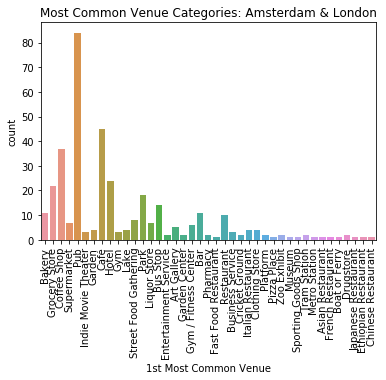

In [132]:
ax = sns.countplot(x="1st Most Common Venue", data=am_lon_merged)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set( title = 'Most Common Venue Categories: Amsterdam & London');

In [88]:
am_lon_merged.columns

Index(['Neighborhood', 'borough', 'latitude', 'longitude', 'city',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

In [89]:
am_lon_merged['Cluster Labels'].value_counts()

0    229
2    109
1     11
3      7
4      5
Name: Cluster Labels, dtype: int64

In [90]:
a = am_lon_merged.groupby(by = ['Cluster Labels', 'city']).count()
a.reset_index(inplace = True)
a

,Cluster Labels,city,Neighborhood,borough,latitude,longitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,0,Amsterdam,67,67,67,67,67,67,67,67,67,67,67,67,67,67
1,0,london,162,162,162,162,162,162,162,162,162,162,162,162,162,162
2,1,Amsterdam,2,2,2,2,2,2,2,2,2,2,2,2,2,2
3,1,london,9,9,9,9,9,9,9,9,9,9,9,9,9,9
4,2,london,109,109,109,109,109,109,109,109,109,109,109,109,109,109
5,3,london,7,7,7,7,7,7,7,7,7,7,7,7,7,7
6,4,london,5,5,5,5,5,5,5,5,5,5,5,5,5,5


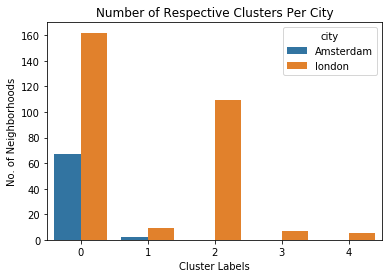

In [92]:
ax = sns.barplot(x="Cluster Labels", y="Neighborhood", hue="city", data=a)
ax.set(xlabel='Cluster Labels', ylabel='No. of Neighborhoods', title = 'Number of Respective Clusters Per City');

The largest clusters are cluster 2 and 0 with 171 neighborhoods. Cluster 2 is only found in London.
The second largest cluster by a long way is cluster 1 with 11 neighborhoods, predominantly London.
The third largest cluster is cluster 3 with 7 neighborhoods. Cluster 3 is only found in London.
Smallest cluster is cluster 4 with 5 clusters. Cluster 4 is only found in London.


### Cluster 0

In [93]:
am_lon_merged.loc[am_lon_merged['Cluster Labels'] == 0, am_lon_merged.columns[[0] + [1]+ [4] + list(range(5, am_lon_merged.shape[1] ))]]

,Neighborhood,borough,city,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Abbey Wood,Bexley,london,0,Bakery,Campground,Café,Food Court,Food & Drink Shop,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
2,Aldgate,City,london,0,Coffee Shop,Hotel,Cocktail Bar,Sushi Restaurant,Burger Joint,Pizza Place,Indian Restaurant,Boxing Gym,Chinese Restaurant,Restaurant
3,Aldwych,Westminster,london,0,Bakery,Steakhouse,Theater,Coffee Shop,Clothing Store,Plaza,Pub,Pizza Place,Ice Cream Shop,Art Museum
4,Anerley,Bromley,london,0,Supermarket,Fast Food Restaurant,Train Station,Gas Station,Hardware Store,Park,Hotel,Music Store,Flower Shop,Entertainment Service
5,Angel,Islington,london,0,Pub,Coffee Shop,Hotel,Gym / Fitness Center,Restaurant,Falafel Restaurant,French Restaurant,Sushi Restaurant,Beer Bar,Food Truck
7,Arnos Grove,Enfield,london,0,Grocery Store,Convenience Store,Train Station,Beer Bar,Fish & Chips Shop,Gym,Flea Market,Exhibit,Empanada Restaurant,English Restaurant
9,Bankside,Southwark,london,0,Pub,Coffee Shop,Italian Restaurant,Seafood Restaurant,Restaurant,Burger Joint,Asian Restaurant,Food Truck,Wine Bar,Hotel
10,Barbican,City,london,0,Pub,Coffee Shop,Hotel,Gym / Fitness Center,Restaurant,Falafel Restaurant,French Restaurant,Sushi Restaurant,Beer Bar,Food Truck
11,Barnes,Richmond upon Thames,london,0,Indie Movie Theater,Restaurant,Movie Theater,Breakfast Spot,Nature Preserve,Bookstore,Farmers Market,Thai Restaurant,Park,Coffee Shop
14,Bayswater,Westminster,london,0,Garden,Hotel,Indian Restaurant,Outdoor Sculpture,Fountain,Restaurant,Stables,Café,Thai Restaurant,French Restaurant


In [94]:
am_lon_merged[am_lon_merged['Cluster Labels'] == 0].groupby(by = 'city').count()['Neighborhood']

city
Amsterdam     67
london       162
Name: Neighborhood, dtype: int64

In [95]:
am_num = am_lon_merged[am_lon_merged['Cluster Labels'] == 0].groupby(by = 'city').count().iloc[0,0]
lon_num = am_lon_merged[am_lon_merged['Cluster Labels'] == 0].groupby(by = 'city').count().iloc[1,0]
perc = am_num/lon_num
perc

0.41358024691358025

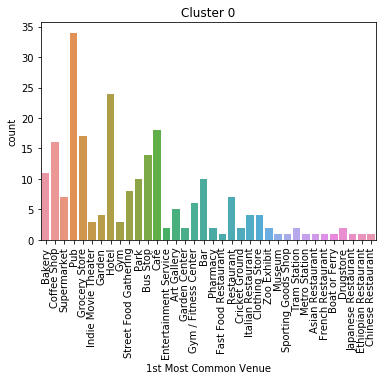

In [125]:
c0 = am_lon_merged[am_lon_merged['Cluster Labels'] == 0]
ax = sns.countplot(x="1st Most Common Venue", data=c0)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set( title = 'Cluster 0');

### Cluster 1

In [96]:
am_lon_merged.loc[am_lon_merged['Cluster Labels'] == 1, am_lon_merged.columns[[0] + [1]+ [4] + list(range(5, am_lon_merged.shape[1]))]]

,Neighborhood,borough,city,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
30,Brent Park,Brent,london,1,Liquor Store,Clothing Store,Restaurant,Fast Food Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
118,Harlesden,Brent,london,1,Liquor Store,Clothing Store,Restaurant,Fast Food Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
138,Kensal Green,Brent,london,1,Liquor Store,Clothing Store,Restaurant,Fast Food Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
157,Little Ilford,Newham,london,1,Restaurant,Fried Chicken Joint,Gas Station,Zoo,Fast Food Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
162,Manor Park,Newham,london,1,Restaurant,Fried Chicken Joint,Gas Station,Zoo,Fast Food Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
191,Old Oak Common,Hammersmith and Fulham,london,1,Liquor Store,Clothing Store,Restaurant,Fast Food Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
196,Park Royal,Brent,london,1,Liquor Store,Clothing Store,Restaurant,Fast Food Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
244,Stonebridge,Brent,london,1,Liquor Store,Clothing Store,Restaurant,Fast Food Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
291,Willesden,Brent,london,1,Liquor Store,Clothing Store,Restaurant,Fast Food Restaurant,English Restaurant,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant
339,Houthaven,West,Amsterdam,1,Restaurant,Modern European Restaurant,Boat or Ferry,Zoo,Filipino Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm


In [97]:
am_lon_merged[am_lon_merged['Cluster Labels'] == 1].groupby(by = 'city').count()['Neighborhood']

city
Amsterdam    2
london       9
Name: Neighborhood, dtype: int64

In [98]:
am_num = am_lon_merged[am_lon_merged['Cluster Labels'] == 1].groupby(by = 'city').count().iloc[0,0]
lon_num = am_lon_merged[am_lon_merged['Cluster Labels'] == 1].groupby(by = 'city').count().iloc[1,0]
perc = am_num/lon_num
perc

0.2222222222222222

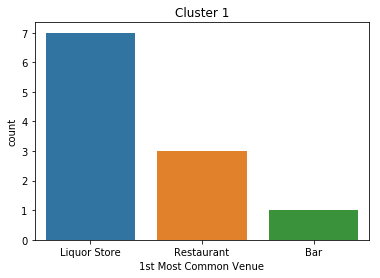

In [127]:
c1 = am_lon_merged[am_lon_merged['Cluster Labels'] == 1]
ax = sns.countplot(x="1st Most Common Venue", data=c1)
ax.set( title = 'Cluster 1');

### Cluster 2

In [99]:
am_lon_merged.loc[am_lon_merged['Cluster Labels'] == 2, am_lon_merged.columns[[0] + [1]+ [4] + list(range(5, am_lon_merged.shape[1]))]]

,Neighborhood,borough,city,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Acton,Ealing,london,2,Grocery Store,Pub,Bakery,Park,Creperie,Hotel,Wine Shop,Miscellaneous Shop,Gas Station,Farm
6,Archway,Islington,london,2,Coffee Shop,Grocery Store,Pub,Indian Restaurant,Bar,Pizza Place,Italian Restaurant,Hotel,Gastropub,Park
8,Balham,Wandsworth,london,2,Coffee Shop,Pub,Bakery,Pizza Place,Italian Restaurant,Indian Restaurant,Bar,Café,Shop & Service,Steakhouse
12,Barnsbury,Islington,london,2,Pub,Café,Gastropub,Deli / Bodega,Coffee Shop,Student Center,Grocery Store,Gym,Gym / Fitness Center,Middle Eastern Restaurant
13,Battersea,Wandsworth,london,2,Pub,Café,Italian Restaurant,Indian Restaurant,Thai Restaurant,Gym,Coffee Shop,Bar,Vietnamese Restaurant,Sushi Restaurant
15,Bedford Park,Ealing,london,2,Café,Pub,Italian Restaurant,Coffee Shop,Creperie,Pharmacy,Park,Gift Shop,Bakery,Sandwich Place
18,Belsize Park,Camden,london,2,Café,Bakery,Pub,Italian Restaurant,Pizza Place,Greek Restaurant,Coffee Shop,Bagel Shop,Bookstore,Grocery Store
20,Bethnal Green,Tower Hamlets,london,2,Coffee Shop,Café,Pub,Cocktail Bar,Pizza Place,Park,Japanese Restaurant,Hotel,Grocery Store,Bar
35,Brondesbury,Brent,london,2,Café,Pub,Indian Restaurant,Brazilian Restaurant,Grocery Store,Coffee Shop,Fast Food Restaurant,Thai Restaurant,Gastropub,Supermarket
38,Camberwell,Southwark,london,2,Café,Coffee Shop,Pub,Grocery Store,Gym / Fitness Center,Middle Eastern Restaurant,Bakery,Park,Bus Stop,Beer Bar


In [100]:
am_lon_merged[am_lon_merged['Cluster Labels'] == 2].groupby(by = 'city').count()['Neighborhood']

city
london    109
Name: Neighborhood, dtype: int64

In [101]:
print ('perc = 1.0')

perc = 1.0


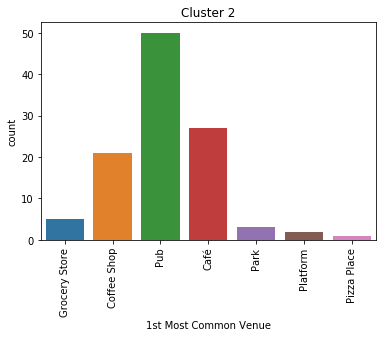

In [128]:
c2 = am_lon_merged[am_lon_merged['Cluster Labels'] == 2]
ax = sns.countplot(x="1st Most Common Venue", data=c2)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set( title = 'Cluster 2');

Looks like there are many pubs listed as the top 1 or two most common venues in these areas.

### Cluster 3

In [102]:
am_lon_merged.loc[am_lon_merged['Cluster Labels'] == 3, am_lon_merged.columns[[0] + [1]+ [4] + list(range(5, am_lon_merged.shape[1]))]]

,Neighborhood,borough,city,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
22,Blackheath,Lewisham,london,3,Lake,Business Service,Zoo,Field,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
23,Blackheath Royal Standard,Greenwich,london,3,Lake,Business Service,Zoo,Field,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
141,Kidbrooke,Greenwich,london,3,Lake,Business Service,Zoo,Field,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
145,Kingston Vale,Kingston upon Thames,london,3,Business Service,Construction & Landscaping,Fish & Chips Shop,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
206,Putney,Wandsworth,london,3,Business Service,Construction & Landscaping,Fish & Chips Shop,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
210,Roehampton,Wandsworth,london,3,Business Service,Construction & Landscaping,Fish & Chips Shop,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
286,Westcombe Park,Greenwich,london,3,Lake,Business Service,Zoo,Field,Entertainment Service,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm


In [103]:
am_lon_merged[am_lon_merged['Cluster Labels'] == 3].groupby(by = 'city').count()['Neighborhood']

city
london    7
Name: Neighborhood, dtype: int64

In [104]:
print ('perc = 1.0')

perc = 1.0


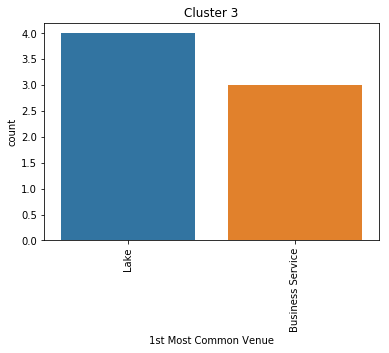

In [129]:
c3 = am_lon_merged[am_lon_merged['Cluster Labels'] == 3]
ax = sns.countplot(x="1st Most Common Venue", data=c3)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set( title = 'Cluster 3');

Looks like these are areas with lakes and businesses/construction with lots of space as there are farmers markets and zoos and fields listed as venues.

### Cluster 4

In [105]:
am_lon_merged.loc[am_lon_merged['Cluster Labels'] == 4, am_lon_merged.columns[[0]+ [1] + [4] + list(range(5, am_lon_merged.shape[1]))]]

,Neighborhood,borough,city,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
87,Eltham,Greenwich,london,4,Park,Golf Course,Soccer Field,Zoo,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
168,Middle Park,Greenwich,london,4,Park,Golf Course,Soccer Field,Zoo,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
174,Mottingham,Bromley,london,4,Park,Golf Course,Soccer Field,Zoo,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
179,New Eltham,Greenwich,london,4,Park,Golf Course,Soccer Field,Zoo,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm
275,Well Hall,Greenwich,london,4,Park,Golf Course,Soccer Field,Zoo,English Restaurant,Ethiopian Restaurant,Event Space,Exhibit,Falafel Restaurant,Farm


In [106]:
am_lon_merged[am_lon_merged['Cluster Labels'] == 4].groupby(by = 'city').count()['Neighborhood']

city
london    5
Name: Neighborhood, dtype: int64

In [107]:
print ('perc = 1.0')

perc = 1.0


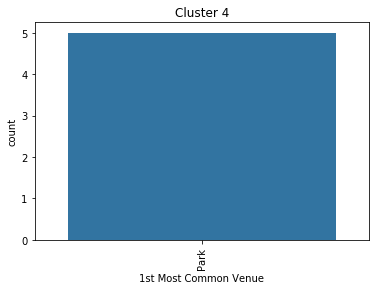

In [130]:
c4 = am_lon_merged[am_lon_merged['Cluster Labels'] == 4]
ax = sns.countplot(x="1st Most Common Venue", data=c4)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
ax.set( title = 'Cluster 4');

Looks like these are areas with lakes and businesses/construction with lots of space as there are farmers markets and zoos and fields listed as venues.

## Last remarks on the clusters

### It seems that if you already live in a neighborhood that's listed in Cluster 3, 4 or 5, there's some bad news. Theres no place like home, and no place like it in Amsterdam.
### If you live in a cluster 1 neighborhood in London then you have 67 Amsterdam neighborhoods that you can look into as they are quite similar
### Lastly, if you live in a cluster 2 neighborhood in London, then you have only have 2 similar nieghborhoods in Amsterdam so there are slim pickings.

In [108]:
# The code was removed by Watson Studio for sharing.

In [109]:
project.save_data(data=am_lon_merged.to_csv(index=False),file_name='amlon.csv',overwrite=True)

{'file_name': 'amlon.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'ibmcourseracapstone-donotdelete-pr-1mldow6qtzmcis',
 'asset_id': '5b4deb62-9824-4cfb-9895-4783e71275cc'}